In [1]:
#import helper
import pandas as pd
#from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

from sklearn.decomposition import PCA

from IPython.display import Image

import pennylane as qml


# Introduction

Stock price prediction is one of the most rewarding problems in modern finance, where the accurate forecasting of future stock prices can yield significant profit and reduce the risks. LSTM (Long Short-Term Memory) is a recurrent Neural Network (RNN) applicable to a broad range of problems aiming to analyze or classify sequential data. Therefore, many people have used LSTM to predict the future stock price based on the historical data sequences with great success.

On the other hand, recent studies have shown that the LSTM's efficiency and trainability can be improved by replacing some of the layers in the LSTM with variational quantum layers, thus making it a quantum-classical hybrid model of LSTM which we will call QLSTM for Quantum LSTM. In the study done by Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang, they show that QLSTM offers better trainability compared to its classical counterpart as it proved to learn significantly more information after the first training epoch than its classical counterpart, learnt the local features better, all while having a comparable number of parameters. Inspired by these recent results, we proceed to test this variational quantum-classical hybrid neural network technique on stock price predictions. 

In the following notebook, we show a proof of concept that QLSTM can be used to great effect for stock price prediction, offering comparable and arguably better results than its classical counterpart. To do so, we implement both LSTM and QLSTM to predict the stock prices of the company Merck & Co. Inc (MRK) with the same number of features, of which we chose based on earlier studies done with stock price predictions.

This submission was motivated by a combination of a few separate studies:

Stock price prediction use BERT and GAN: https://arxiv.org/pdf/2107.09055.pdf, Priyank Sonkiya, Vikas Bajpai, Anukriti Bansal <br>
Quantum Long Short-Term Memory: https://arxiv.org/pdf/2009.01783.pdf, Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang <br>

With code and ideas reused and repurposed from the following sources:

Example of a QLSTM: https://github.com/rdisipio/qlstm, Riccardo Di Sipio <br>
How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent <br>
Using GANs to predict stock price movement: https://towardsdatascience.com/aifortrading-2edd6fac689d, Boris Banushev<br>

## Brief Outline

To demonstrate the use of QLSTM for stock prediction, we use the stock prices of the company Merck & Co. Inc (MRK). The notebook will proceed in the following manner:

1. Brief description of Data
2. Using Classical LSTM to perform stock price prediction
3. Defining QLSTM and using it to perform stock price prediction
4. Comparison between LSTM and QLSTM

Note that for the LSTM, we would be using PyTorch; while for the QLSTM we would be using PyTorch and Pennylane. 

# Experimentation

- weight decay coefficient (weight decay), 
- width of the layer (width), 
- mini-batch size (batch size), 
- learning rate (learning rate),
- dropout probability (dropout), 
- depth of the architecture(depth) 
- the choice of the optimization algorithms (optimizer)

number of iterations = batch_size * num_epochs

In [2]:
batch_size = 1
sequence_length = 3

weight_decay_value = 0
learning_rate = 0.0001

num_hidden_units = 16

In [3]:
#from torch.utils.tensorboard import SummaryWriter

In [4]:
#writer = SummaryWriter()

# Data

To briefly describe the data, we have collected the historical data of the MRK stock prices, of which we focus on the closing price. Our goal is then to forecast the closing stock prices of MRK using LSTM (or QLSTM). 

To achieve this goal, we have collected the data and information we thought necessary and important. This includes the following:

- Technical indicators
- Trend approximations (Fourier Transforms)
- ARIMA 
- Correlated assets
- Sentimental analysis

While interesting and important in its own right, we have decided not to go into detail for the data collection in this notebook. For more information, please go take a look at the Data Collection notebook also in this Github. 

In this section, our goal is to process the data to get it ready for the LSTM and QLSTM.

First, we read in the data, dropping the index and the date.

In [5]:
df = pd.read_csv('dataset_MRK_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,...,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450,31.440840
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,...,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840,31.183207
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,...,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207,31.364504
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,...,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504,30.839695
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,...,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695,30.944656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,1.705192,78.113220,71.292452,...,38.856968,148.141144,82.393753,12302.190430,9682.910156,57.910147,55.622779,55.790021,76.887436,77.814888
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,...,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500,78.492363
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,...,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240,79.103050
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,...,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688,78.492363


We identify the dependent and independent variables:

In [6]:
target = "Close_lead1"

In [7]:
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

## Data Processing

To process the data, we first split it into training and test data, where two-thirds of the data is used for training, and the last third is used for testing.

In [8]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

Next, in order to ensure that some values don't inherently dominate the features due to their magnitude, we standardize their values.

In [9]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [10]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

Finally, the last step in the data processing to prepare it for LSTM is to prepare the data in a sequence of past observations. Preparing LSTM on time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance. If the sequence length is $n$, then the LSTM considers the last $n$ observations to predict the $n+1$th day.

The sequence length we decided on is 3 for purposes of this notebook.

In [11]:
torch.manual_seed(101)

#batch_size = 10
#sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 32])
Target shape: torch.Size([1])


In [12]:
i = 0
for _ in train_loader:
    i += 1 
print(i)

1821


# Classical LSTM

We first define two functions:
    
- train_model: function to train the model based on the batches of data
- test_model: function to test the model on the testing data
    
For both, they print the loss at the end to let us know how the model is performing with regards to the data.

In [13]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def trading_model(data_loader, model, loss_function, initial_inv, initial_price):
    
    # initial seed money
    inv = initial_inv
    
    # initial price of stock
    price = initial_price
    
    # initial number of stock 
    number_stocks = 0
    
    # predicted earnings
    pred_earn = 0 
    
    # predicted stock
    pred_output = []
    
    # day
    day = 1
    
    for X, y in data_loader:
        model.eval()
        with torch.no_grad():
            output = model(X)
            
            pred_price =  output * target_stdev + target_mean
            pred_output.append(pred_price)
            print("Today's stock price: ", price)
            print("Predicted stock price for tomorrow: ", pred_price)
            
            #if predicted value next day higher than today's price
            if pred_price > price:
                number_stocks = number_stocks + inv/price
                inv = 0
                print("Day", day, ": Bought ", number_stocks, "stocks at price ", price)
                pred_earn = pred_earn + number_stocks * (pred_price - price)
                print("Predicted earnings: ", pred_earn)
                
                
            #if predicted value next day lower than (or equal to)  today's price
            else:
                inv = inv + number_stocks * price
                print("Day", day, ": Sold ", number_stocks, "at price ", price)
                number_stocks = 0
            
            # Update price
            price = y * target_stdev + target_mean
            day += 1
            print("Current number of stocks: ", number_stocks)
            print("Current seed money:", inv)
        
        model.train()
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    total_earnings = number_stocks*price + inv
    print(f"Trading earnings: {total_earnings}")
    print(f"Predicted earnings: {pred_earn}")
    return pred_output
    


## Running the Classical LSTM

To understand how we implemented QLSTM, we have to first understand how we implemented LSTM. LSTM follows the following structure:

<img src="lstm2.jpg" alt="drawing" width="400"/>

Image taken from: Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf. By Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang

Simply put, LSTM uses 4 neural network layers in each LSTM cell to perform its functions. They are:

- Forget layer
- Input layer
- Update layer
- Output layer

You can see the corresponding layers in the W cells in the picture above. We will be skipping the technical details, as you can find better information on the theory elsewhere, but it is important to note that these 4 layers are the key to building an LSTM neural network model that we can train and eventually use to predict, and usually take the form of a normal NN layer (like a linear layer with reLU or convolutional layers).

LSTMs are well studied, and there is a native implementation of it in PyTorch to begin with, so we use a slightly modified version of it for the time series LSTM that we perform here. The code for the time series LSTM was reused from:

How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent.

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. The learning rate of 0.0001 was decided after some experimentation, where we chose the learning rate that most reliably gave accurate results. The number of epochs we use is 20, by which it would have converged and thus would suffice for the purposes of this notebook. After that, we proceed to see 3 different graphs: the comparison between the real stock prices and the ones given by the model; and the evolution of test loss and training loss by epoch.

# Experimentation

In [14]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [15]:
#learning_rate = 0.0001
#num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_value)

In [16]:
classical_loss_train = []
classical_loss_test = []
classical_time = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)
classical_loss_test.append(test_loss)
classical_time.append(end - start)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    end = time.time()
    print("Execution time", end - start)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)
    classical_time.append(end - start)

Untrained test
--------
Test loss: 8.772961116953438
Execution time 0.4687459468841553
Epoch 0
---------


C:\Users\jonas\Anaconda3\envs\qrnn\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train loss: 0.28158706967871294
Test loss: 2.3835824306579205
Execution time 6.4624950885772705
Epoch 1
---------
Train loss: 0.03392057837583039
Test loss: 1.8460188952437762
Execution time 6.316291809082031
Epoch 2
---------
Train loss: 0.016647744728467688
Test loss: 1.6813875911367495
Execution time 5.502443313598633
Epoch 3
---------
Train loss: 0.011585193470526185
Test loss: 1.543614531745642
Execution time 4.781730890274048
Epoch 4
---------
Train loss: 0.009520245339513225
Test loss: 1.4201251326165412
Execution time 5.015035629272461
Epoch 5
---------
Train loss: 0.008369409375870442
Test loss: 1.370000918273736
Execution time 4.694565773010254
Epoch 6
---------
Train loss: 0.0074685324805591115
Test loss: 1.3699616962024048
Execution time 4.846810817718506
Epoch 7
---------
Train loss: 0.006935218207444897
Test loss: 1.2508469912372722
Execution time 4.828796148300171
Epoch 8
---------
Train loss: 0.006410122015030243
Test loss: 1.2514511358240428
Execution time 4.7701709270

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [17]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [18]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       31.440840       30.351990
1       31.183207       30.470472
2       31.364504       30.750546
3       30.839695       30.927803
4       30.944656       30.721352
...           ...             ...
2712    77.814888       65.669739
2713    78.492363       65.706108
2714    79.103050       65.636116
2715    78.492363       65.874496
2716    78.024811       65.792358

[2718 rows x 2 columns]


In [19]:
df_out = df_out[~df_out.index.duplicated(keep='first')]

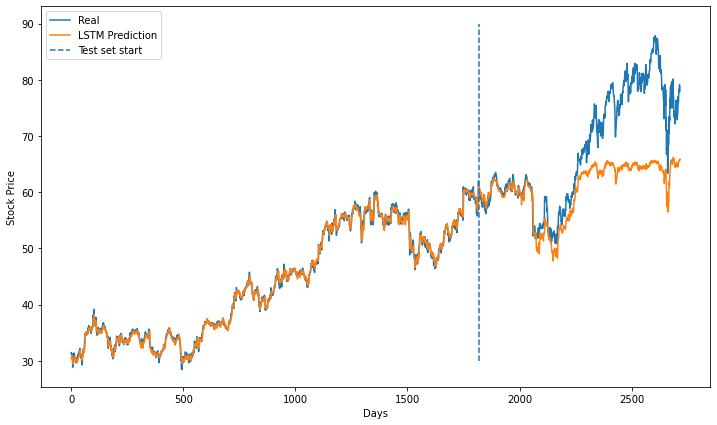

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_out)), df_out["Close_lead1"], label = "Real")
plt.plot(range(len(df_out)), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

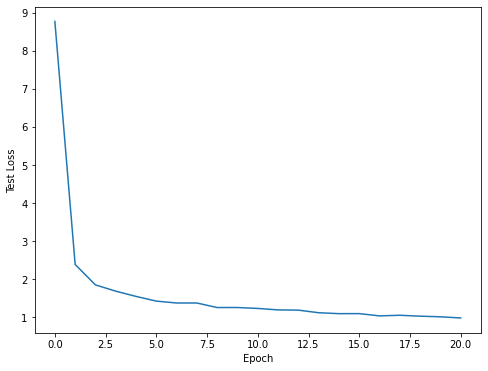

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

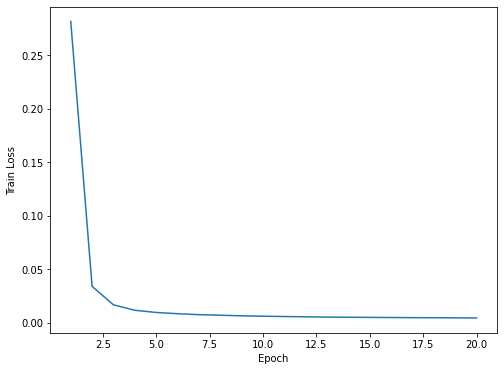

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

# Trading

In [23]:
df_out["Close_lead1"][size - 1]

60.620228

In [24]:
initial_inv = 10000
initial_price = df_out["Close_lead1"][size - 1]

In [25]:
pred_output = trading_model(test_loader, model, loss_function, initial_inv, initial_price)

Today's stock price:  60.620228
Predicted stock price for tomorrow:  tensor([58.6349])
Day 1 : Sold  0 at price  60.620228
Current number of stocks:  0
Current seed money: 10000.0
Today's stock price:  tensor([60.7347])
Predicted stock price for tomorrow:  tensor([60.4896])
Day 2 : Sold  0 at price  tensor([60.7347])
Current number of stocks:  0
Current seed money: tensor([10000.])
Today's stock price:  tensor([59.7615])
Predicted stock price for tomorrow:  tensor([60.6377])
Day 3 : Bought  tensor([167.3319]) stocks at price  tensor([59.7615])
Predicted earnings:  tensor([146.6210])
Current number of stocks:  tensor([167.3319])
Current seed money: 0
Today's stock price:  tensor([59.8282])
Predicted stock price for tomorrow:  tensor([60.6394])
Day 4 : Bought  tensor([167.3319]) stocks at price  tensor([59.8282])
Predicted earnings:  tensor([282.3497])
Current number of stocks:  tensor([167.3319])
Current seed money: 0
Today's stock price:  tensor([59.0363])
Predicted stock price for tom

Day 33 : Bought  tensor([167.5782]) stocks at price  tensor([56.1737])
Predicted earnings:  tensor([2085.6064])
Current number of stocks:  tensor([167.5782])
Current seed money: 0
Today's stock price:  tensor([57.3950])
Predicted stock price for tomorrow:  tensor([56.7457])
Day 34 : Sold  tensor([167.5782]) at price  tensor([57.3950])
Current number of stocks:  0
Current seed money: tensor([9618.1602])
Today's stock price:  tensor([57.3760])
Predicted stock price for tomorrow:  tensor([56.9680])
Day 35 : Sold  0 at price  tensor([57.3760])
Current number of stocks:  0
Current seed money: tensor([9618.1602])
Today's stock price:  tensor([57.3569])
Predicted stock price for tomorrow:  tensor([56.9893])
Day 36 : Sold  0 at price  tensor([57.3569])
Current number of stocks:  0
Current seed money: tensor([9618.1602])
Today's stock price:  tensor([57.5095])
Predicted stock price for tomorrow:  tensor([57.1035])
Day 37 : Sold  0 at price  tensor([57.5095])
Current number of stocks:  0
Current

Today's stock price:  tensor([62.8721])
Predicted stock price for tomorrow:  tensor([62.6140])
Day 79 : Sold  0 at price  tensor([62.8721])
Current number of stocks:  0
Current seed money: tensor([10428.8857])
Today's stock price:  tensor([62.5954])
Predicted stock price for tomorrow:  tensor([62.8960])
Day 80 : Bought  tensor([166.6078]) stocks at price  tensor([62.5954])
Predicted earnings:  tensor([2974.5522])
Current number of stocks:  tensor([166.6078])
Current seed money: 0
Today's stock price:  tensor([61.2118])
Predicted stock price for tomorrow:  tensor([62.2450])
Day 81 : Bought  tensor([166.6078]) stocks at price  tensor([61.2118])
Predicted earnings:  tensor([3146.6882])
Current number of stocks:  tensor([166.6078])
Current seed money: 0
Today's stock price:  tensor([61.2595])
Predicted stock price for tomorrow:  tensor([61.9913])
Day 82 : Bought  tensor([166.6078]) stocks at price  tensor([61.2595])
Predicted earnings:  tensor([3268.6003])
Current number of stocks:  tensor

Day 118 : Sold  0 at price  tensor([60.4771])
Current number of stocks:  0
Current seed money: tensor([10246.2959])
Today's stock price:  tensor([61.0401])
Predicted stock price for tomorrow:  tensor([60.7241])
Day 119 : Sold  0 at price  tensor([61.0401])
Current number of stocks:  0
Current seed money: tensor([10246.2959])
Today's stock price:  tensor([61.0782])
Predicted stock price for tomorrow:  tensor([60.9651])
Day 120 : Sold  0 at price  tensor([61.0782])
Current number of stocks:  0
Current seed money: tensor([10246.2959])
Today's stock price:  tensor([60.3912])
Predicted stock price for tomorrow:  tensor([60.9894])
Day 121 : Bought  tensor([169.6653]) stocks at price  tensor([60.3912])
Predicted earnings:  tensor([4531.0879])
Current number of stocks:  tensor([169.6653])
Current seed money: 0
Today's stock price:  tensor([61.0115])
Predicted stock price for tomorrow:  tensor([61.0523])
Day 122 : Bought  tensor([169.6653]) stocks at price  tensor([61.0115])
Predicted earnings:

Today's stock price:  tensor([62.9008])
Predicted stock price for tomorrow:  tensor([62.2111])
Day 154 : Sold  0 at price  tensor([62.9008])
Current number of stocks:  0
Current seed money: tensor([10402.1504])
Today's stock price:  tensor([62.5382])
Predicted stock price for tomorrow:  tensor([62.5881])
Day 155 : Bought  tensor([166.3328]) stocks at price  tensor([62.5382])
Predicted earnings:  tensor([5833.8794])
Current number of stocks:  tensor([166.3328])
Current seed money: 0
Today's stock price:  tensor([62.1756])
Predicted stock price for tomorrow:  tensor([61.6476])
Day 156 : Sold  tensor([166.3328]) at price  tensor([62.1756])
Current number of stocks:  0
Current seed money: tensor([10341.8389])
Today's stock price:  tensor([61.3931])
Predicted stock price for tomorrow:  tensor([61.8012])
Day 157 : Bought  tensor([168.4527]) stocks at price  tensor([61.3931])
Predicted earnings:  tensor([5902.6177])
Current number of stocks:  tensor([168.4527])
Current seed money: 0
Today's s

Today's stock price:  tensor([60.4198])
Predicted stock price for tomorrow:  tensor([59.7448])
Day 198 : Sold  0 at price  tensor([60.4198])
Current number of stocks:  0
Current seed money: tensor([10507.6299])
Today's stock price:  tensor([60.2290])
Predicted stock price for tomorrow:  tensor([60.1344])
Day 199 : Sold  0 at price  tensor([60.2290])
Current number of stocks:  0
Current seed money: tensor([10507.6299])
Today's stock price:  tensor([60.2290])
Predicted stock price for tomorrow:  tensor([60.5690])
Day 200 : Bought  tensor([174.4613]) stocks at price  tensor([60.2290])
Predicted earnings:  tensor([7220.6479])
Current number of stocks:  tensor([174.4613])
Current seed money: 0
Today's stock price:  tensor([60.9351])
Predicted stock price for tomorrow:  tensor([59.0762])
Day 201 : Sold  tensor([174.4613]) at price  tensor([60.9351])
Current number of stocks:  0
Current seed money: tensor([10630.8184])
Today's stock price:  tensor([60.9065])
Predicted stock price for tomorrow

Today's stock price:  tensor([52.5668])
Predicted stock price for tomorrow:  tensor([52.9061])
Day 243 : Bought  tensor([177.1086]) stocks at price  tensor([52.5668])
Predicted earnings:  tensor([9949.3506])
Current number of stocks:  tensor([177.1086])
Current seed money: 0
Today's stock price:  tensor([52.8053])
Predicted stock price for tomorrow:  tensor([52.5060])
Day 244 : Sold  tensor([177.1086]) at price  tensor([52.8053])
Current number of stocks:  0
Current seed money: tensor([9352.2783])
Today's stock price:  tensor([52.8340])
Predicted stock price for tomorrow:  tensor([52.5012])
Day 245 : Sold  0 at price  tensor([52.8340])
Current number of stocks:  0
Current seed money: tensor([9352.2783])
Today's stock price:  tensor([53.4924])
Predicted stock price for tomorrow:  tensor([52.5173])
Day 246 : Sold  0 at price  tensor([53.4924])
Current number of stocks:  0
Current seed money: tensor([9352.2783])
Today's stock price:  tensor([53.3206])
Predicted stock price for tomorrow:  

Predicted stock price for tomorrow:  tensor([53.7928])
Day 286 : Bought  tensor([172.9538]) stocks at price  tensor([53.5687])
Predicted earnings:  tensor([11104.6543])
Current number of stocks:  tensor([172.9538])
Current seed money: 0
Today's stock price:  tensor([54.4370])
Predicted stock price for tomorrow:  tensor([53.8580])
Day 287 : Sold  tensor([172.9538]) at price  tensor([54.4370])
Current number of stocks:  0
Current seed money: tensor([9415.0918])
Today's stock price:  tensor([54.3798])
Predicted stock price for tomorrow:  tensor([54.0606])
Day 288 : Sold  0 at price  tensor([54.3798])
Current number of stocks:  0
Current seed money: tensor([9415.0918])
Today's stock price:  tensor([54.0649])
Predicted stock price for tomorrow:  tensor([54.7935])
Day 289 : Bought  tensor([174.1443]) stocks at price  tensor([54.0649])
Predicted earnings:  tensor([11231.5381])
Current number of stocks:  tensor([174.1443])
Current seed money: 0
Today's stock price:  tensor([54.1985])
Predicted

Predicted stock price for tomorrow:  tensor([50.4380])
Day 331 : Sold  0 at price  tensor([52.6145])
Current number of stocks:  0
Current seed money: tensor([8742.9551])
Today's stock price:  tensor([52.8244])
Predicted stock price for tomorrow:  tensor([51.1820])
Day 332 : Sold  0 at price  tensor([52.8244])
Current number of stocks:  0
Current seed money: tensor([8742.9551])
Today's stock price:  tensor([52.8340])
Predicted stock price for tomorrow:  tensor([51.4618])
Day 333 : Sold  0 at price  tensor([52.8340])
Current number of stocks:  0
Current seed money: tensor([8742.9551])
Today's stock price:  tensor([52.2901])
Predicted stock price for tomorrow:  tensor([51.5576])
Day 334 : Sold  0 at price  tensor([52.2901])
Current number of stocks:  0
Current seed money: tensor([8742.9551])
Today's stock price:  tensor([52.7195])
Predicted stock price for tomorrow:  tensor([51.6870])
Day 335 : Sold  0 at price  tensor([52.7195])
Current number of stocks:  0
Current seed money: tensor([87

Today's stock price:  tensor([55.1050])
Predicted stock price for tomorrow:  tensor([55.4890])
Day 370 : Bought  tensor([172.7020]) stocks at price  tensor([55.1050])
Predicted earnings:  tensor([18624.5117])
Current number of stocks:  tensor([172.7020])
Current seed money: 0
Today's stock price:  tensor([54.7519])
Predicted stock price for tomorrow:  tensor([55.5289])
Day 371 : Bought  tensor([172.7020]) stocks at price  tensor([54.7519])
Predicted earnings:  tensor([18758.6914])
Current number of stocks:  tensor([172.7020])
Current seed money: 0
Today's stock price:  tensor([54.1603])
Predicted stock price for tomorrow:  tensor([55.2729])
Day 372 : Bought  tensor([172.7020]) stocks at price  tensor([54.1603])
Predicted earnings:  tensor([18950.8359])
Current number of stocks:  tensor([172.7020])
Current seed money: 0
Today's stock price:  tensor([55.2958])
Predicted stock price for tomorrow:  tensor([55.5584])
Day 373 : Bought  tensor([172.7020]) stocks at price  tensor([55.2958])
Pr

Today's stock price:  tensor([57.6908])
Predicted stock price for tomorrow:  tensor([59.0434])
Day 410 : Bought  tensor([169.7297]) stocks at price  tensor([57.6908])
Predicted earnings:  tensor([22651.5469])
Current number of stocks:  tensor([169.7297])
Current seed money: 0
Today's stock price:  tensor([57.9294])
Predicted stock price for tomorrow:  tensor([58.6775])
Day 411 : Bought  tensor([169.7297]) stocks at price  tensor([57.9294])
Predicted earnings:  tensor([22778.5176])
Current number of stocks:  tensor([169.7297])
Current seed money: 0
Today's stock price:  tensor([58.8168])
Predicted stock price for tomorrow:  tensor([58.8320])
Day 412 : Bought  tensor([169.7297]) stocks at price  tensor([58.8168])
Predicted earnings:  tensor([22781.0938])
Current number of stocks:  tensor([169.7297])
Current seed money: 0
Today's stock price:  tensor([59.3511])
Predicted stock price for tomorrow:  tensor([58.9975])
Day 413 : Sold  tensor([169.7297]) at price  tensor([59.3511])
Current num

Day 451 : Sold  0 at price  tensor([65.6584])
Current number of stocks:  0
Current seed money: tensor([10903.2344])
Today's stock price:  tensor([65.4008])
Predicted stock price for tomorrow:  tensor([65.1764])
Day 452 : Sold  0 at price  tensor([65.4008])
Current number of stocks:  0
Current seed money: tensor([10903.2344])
Today's stock price:  tensor([65.4485])
Predicted stock price for tomorrow:  tensor([65.2525])
Day 453 : Sold  0 at price  tensor([65.4485])
Current number of stocks:  0
Current seed money: tensor([10903.2344])
Today's stock price:  tensor([64.8378])
Predicted stock price for tomorrow:  tensor([65.2186])
Day 454 : Bought  tensor([168.1617]) stocks at price  tensor([64.8378])
Predicted earnings:  tensor([23282.6719])
Current number of stocks:  tensor([168.1617])
Current seed money: 0
Today's stock price:  tensor([65.4771])
Predicted stock price for tomorrow:  tensor([65.3287])
Day 455 : Sold  tensor([168.1617]) at price  tensor([65.4771])
Current number of stocks:  

Day 496 : Sold  0 at price  tensor([69.7710])
Current number of stocks:  0
Current seed money: tensor([11617.6914])
Today's stock price:  tensor([68.9599])
Predicted stock price for tomorrow:  tensor([68.2182])
Day 497 : Sold  0 at price  tensor([68.9599])
Current number of stocks:  0
Current seed money: tensor([11617.6914])
Today's stock price:  tensor([69.7710])
Predicted stock price for tomorrow:  tensor([68.2766])
Day 498 : Sold  0 at price  tensor([69.7710])
Current number of stocks:  0
Current seed money: tensor([11617.6914])
Today's stock price:  tensor([69.9523])
Predicted stock price for tomorrow:  tensor([68.3942])
Day 499 : Sold  0 at price  tensor([69.9523])
Current number of stocks:  0
Current seed money: tensor([11617.6914])
Today's stock price:  tensor([71.6412])
Predicted stock price for tomorrow:  tensor([68.7535])
Day 500 : Sold  0 at price  tensor([71.6412])
Current number of stocks:  0
Current seed money: tensor([11617.6914])
Today's stock price:  tensor([72.0229])


Today's stock price:  tensor([71.1927])
Predicted stock price for tomorrow:  tensor([71.2256])
Day 546 : Bought  tensor([171.1432]) stocks at price  tensor([71.1927])
Predicted earnings:  tensor([24641.6934])
Current number of stocks:  tensor([171.1432])
Current seed money: 0
Today's stock price:  tensor([72.1374])
Predicted stock price for tomorrow:  tensor([71.3920])
Day 547 : Sold  tensor([171.1432]) at price  tensor([72.1374])
Current number of stocks:  0
Current seed money: tensor([12345.8271])
Today's stock price:  tensor([72.3950])
Predicted stock price for tomorrow:  tensor([71.5330])
Day 548 : Sold  0 at price  tensor([72.3950])
Current number of stocks:  0
Current seed money: tensor([12345.8271])
Today's stock price:  tensor([72.3569])
Predicted stock price for tomorrow:  tensor([71.5876])
Day 549 : Sold  0 at price  tensor([72.3569])
Current number of stocks:  0
Current seed money: tensor([12345.8271])
Today's stock price:  tensor([71.9847])
Predicted stock price for tomorro

Current number of stocks:  0
Current seed money: tensor([12899.2549])
Today's stock price:  tensor([78.5782])
Predicted stock price for tomorrow:  tensor([74.3126])
Day 592 : Sold  0 at price  tensor([78.5782])
Current number of stocks:  0
Current seed money: tensor([12899.2549])
Today's stock price:  tensor([79.1221])
Predicted stock price for tomorrow:  tensor([74.3861])
Day 593 : Sold  0 at price  tensor([79.1221])
Current number of stocks:  0
Current seed money: tensor([12899.2549])
Today's stock price:  tensor([78.5210])
Predicted stock price for tomorrow:  tensor([74.4469])
Day 594 : Sold  0 at price  tensor([78.5210])
Current number of stocks:  0
Current seed money: tensor([12899.2549])
Today's stock price:  tensor([78.8454])
Predicted stock price for tomorrow:  tensor([74.4708])
Day 595 : Sold  0 at price  tensor([78.8454])
Current number of stocks:  0
Current seed money: tensor([12899.2549])
Today's stock price:  tensor([79.3607])
Predicted stock price for tomorrow:  tensor([7

Today's stock price:  tensor([75.5821])
Predicted stock price for tomorrow:  tensor([75.0896])
Day 639 : Sold  0 at price  tensor([75.5821])
Current number of stocks:  0
Current seed money: tensor([13297.2070])
Today's stock price:  tensor([76.5840])
Predicted stock price for tomorrow:  tensor([75.1235])
Day 640 : Sold  0 at price  tensor([76.5840])
Current number of stocks:  0
Current seed money: tensor([13297.2070])
Today's stock price:  tensor([77.3664])
Predicted stock price for tomorrow:  tensor([75.2471])
Day 641 : Sold  0 at price  tensor([77.3664])
Current number of stocks:  0
Current seed money: tensor([13297.2070])
Today's stock price:  tensor([77.9485])
Predicted stock price for tomorrow:  tensor([75.2889])
Day 642 : Sold  0 at price  tensor([77.9485])
Current number of stocks:  0
Current seed money: tensor([13297.2070])
Today's stock price:  tensor([77.7099])
Predicted stock price for tomorrow:  tensor([75.3450])
Day 643 : Sold  0 at price  tensor([77.7099])
Current number 

Current seed money: tensor([13502.3428])
Today's stock price:  tensor([82.2424])
Predicted stock price for tomorrow:  tensor([77.8675])
Day 694 : Sold  0 at price  tensor([82.2424])
Current number of stocks:  0
Current seed money: tensor([13502.3428])
Today's stock price:  tensor([81.7271])
Predicted stock price for tomorrow:  tensor([77.9213])
Day 695 : Sold  0 at price  tensor([81.7271])
Current number of stocks:  0
Current seed money: tensor([13502.3428])
Today's stock price:  tensor([82.9294])
Predicted stock price for tomorrow:  tensor([78.0222])
Day 696 : Sold  0 at price  tensor([82.9294])
Current number of stocks:  0
Current seed money: tensor([13502.3428])
Today's stock price:  tensor([82.7481])
Predicted stock price for tomorrow:  tensor([78.1140])
Day 697 : Sold  0 at price  tensor([82.7481])
Current number of stocks:  0
Current seed money: tensor([13502.3428])
Today's stock price:  tensor([81.0496])
Predicted stock price for tomorrow:  tensor([78.0502])
Day 698 : Sold  0 at

Today's stock price:  tensor([81.1450])
Predicted stock price for tomorrow:  tensor([78.9591])
Day 734 : Sold  0 at price  tensor([81.1450])
Current number of stocks:  0
Current seed money: tensor([13975.0166])
Today's stock price:  tensor([80.5821])
Predicted stock price for tomorrow:  tensor([78.9893])
Day 735 : Sold  0 at price  tensor([80.5821])
Current number of stocks:  0
Current seed money: tensor([13975.0166])
Today's stock price:  tensor([79.9618])
Predicted stock price for tomorrow:  tensor([79.0323])
Day 736 : Sold  0 at price  tensor([79.9618])
Current number of stocks:  0
Current seed money: tensor([13975.0166])
Today's stock price:  tensor([80.8015])
Predicted stock price for tomorrow:  tensor([79.0669])
Day 737 : Sold  0 at price  tensor([80.8015])
Current number of stocks:  0
Current seed money: tensor([13975.0166])
Today's stock price:  tensor([80.6489])
Predicted stock price for tomorrow:  tensor([79.0399])
Day 738 : Sold  0 at price  tensor([80.6489])
Current number 

Today's stock price:  tensor([86.7843])
Predicted stock price for tomorrow:  tensor([80.6916])
Day 787 : Sold  0 at price  tensor([86.7843])
Current number of stocks:  0
Current seed money: tensor([14864.2588])
Today's stock price:  tensor([87.8244])
Predicted stock price for tomorrow:  tensor([80.7543])
Day 788 : Sold  0 at price  tensor([87.8244])
Current number of stocks:  0
Current seed money: tensor([14864.2588])
Today's stock price:  tensor([87.0706])
Predicted stock price for tomorrow:  tensor([80.7869])
Day 789 : Sold  0 at price  tensor([87.0706])
Current number of stocks:  0
Current seed money: tensor([14864.2588])
Today's stock price:  tensor([87.4427])
Predicted stock price for tomorrow:  tensor([80.8621])
Day 790 : Sold  0 at price  tensor([87.4427])
Current number of stocks:  0
Current seed money: tensor([14864.2588])
Today's stock price:  tensor([85.1145])
Predicted stock price for tomorrow:  tensor([80.8728])
Day 791 : Sold  0 at price  tensor([85.1145])
Current number 

Today's stock price:  tensor([74.5038])
Predicted stock price for tomorrow:  tensor([80.7005])
Day 826 : Bought  tensor([183.9758]) stocks at price  tensor([74.5038])
Predicted earnings:  tensor([37559.4570])
Current number of stocks:  tensor([183.9758])
Current seed money: 0
Today's stock price:  tensor([73.0534])
Predicted stock price for tomorrow:  tensor([80.0081])
Day 827 : Bought  tensor([183.9758]) stocks at price  tensor([73.0534])
Predicted earnings:  tensor([38838.9414])
Current number of stocks:  tensor([183.9758])
Current seed money: 0
Today's stock price:  tensor([77.6431])
Predicted stock price for tomorrow:  tensor([80.6011])
Day 828 : Bought  tensor([183.9758]) stocks at price  tensor([77.6431])
Predicted earnings:  tensor([39383.1445])
Current number of stocks:  tensor([183.9758])
Current seed money: 0
Today's stock price:  tensor([75.5057])
Predicted stock price for tomorrow:  tensor([80.2993])
Day 829 : Bought  tensor([183.9758]) stocks at price  tensor([75.5057])
Pr

Today's stock price:  tensor([74.9618])
Predicted stock price for tomorrow:  tensor([77.7494])
Day 863 : Bought  tensor([193.9989]) stocks at price  tensor([74.9618])
Predicted earnings:  tensor([60966.8555])
Current number of stocks:  tensor([193.9989])
Current seed money: 0
Today's stock price:  tensor([76.3168])
Predicted stock price for tomorrow:  tensor([78.4284])
Day 864 : Bought  tensor([193.9989]) stocks at price  tensor([76.3168])
Predicted earnings:  tensor([61376.5117])
Current number of stocks:  tensor([193.9989])
Current seed money: 0
Today's stock price:  tensor([77.1756])
Predicted stock price for tomorrow:  tensor([79.4113])
Day 865 : Bought  tensor([193.9989]) stocks at price  tensor([77.1756])
Predicted earnings:  tensor([61810.2383])
Current number of stocks:  tensor([193.9989])
Current seed money: 0
Today's stock price:  tensor([77.7004])
Predicted stock price for tomorrow:  tensor([80.0020])
Day 866 : Bought  tensor([193.9989]) stocks at price  tensor([77.7004])
Pr

In [26]:
pred_output

[tensor([58.6349]),
 tensor([60.4896]),
 tensor([60.6377]),
 tensor([60.6394]),
 tensor([60.3106]),
 tensor([60.2165]),
 tensor([59.8269]),
 tensor([59.7902]),
 tensor([59.6561]),
 tensor([59.2315]),
 tensor([59.5486]),
 tensor([59.0825]),
 tensor([58.4675]),
 tensor([58.5537]),
 tensor([58.0273]),
 tensor([58.0514]),
 tensor([57.7358]),
 tensor([57.7405]),
 tensor([57.6275]),
 tensor([57.9367]),
 tensor([58.3704]),
 tensor([58.3105]),
 tensor([58.5540]),
 tensor([58.7490]),
 tensor([58.6742]),
 tensor([58.3494]),
 tensor([57.5141]),
 tensor([57.0622]),
 tensor([57.0576]),
 tensor([57.1111]),
 tensor([56.6026]),
 tensor([56.6166]),
 tensor([56.3472]),
 tensor([56.7457]),
 tensor([56.9680]),
 tensor([56.9893]),
 tensor([57.1035]),
 tensor([57.5572]),
 tensor([57.7527]),
 tensor([57.9232]),
 tensor([58.5344]),
 tensor([59.0911]),
 tensor([58.9601]),
 tensor([58.6804]),
 tensor([58.2620]),
 tensor([59.0298]),
 tensor([59.1929]),
 tensor([59.0767]),
 tensor([59.0428]),
 tensor([59.1061]),


C:\Users\jonas\Anaconda3\envs\qrnn\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\jonas\Anaconda3\envs\qrnn\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


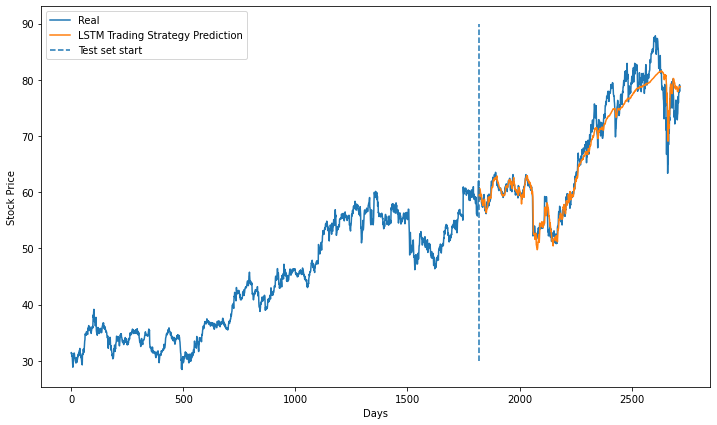

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_out)), df_out["Close_lead1"], label = "Real")
plt.plot(range(size, len(df_out)), pred_output, label = "LSTM Trading Strategy Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [ ]:
import csv

In [ ]:
with open('test.csv', 'a', newline='') as test_csv:
    test_csv_writer = csv.writer(test_csv)
    test_csv_writer.writerow(classical_loss_test)

In [ ]:
with open('train.csv', 'a', newline='') as train_csv:
    train_csv_writer = csv.writer(train_csv)
    train_csv_writer.writerow(classical_loss_train)

In [ ]:
with open('pred.csv', 'a', newline='') as pred_csv:
    pred_csv_writer = csv.writer(pred_csv)
    pred_csv_writer.writerow(df_out["Model forecast"])

In [ ]:
for i in range(len(classical_loss_test)):
    writer.add_scalar("Test loss",classical_loss_test[i], i)
    
for i in range(len(classical_loss_train)):
    writer.add_scalar("Train loss: ", classical_loss_train[i], i)
    
for i in range(len(df_out["Model forecast"])):
    writer.add_scalar("Predicted Value: ", df_out["Model forecast"][i], i)
    
writer.close()

## Number of parameters used

In [ ]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

## Complexity analysis

As a last point of comparison, we want to discuss the complexity analysis for the QLSTM, as well as compare the number of parameters used for the LSTM and the QLSTM.

Given that we would want to eventually use the QLSTM on real quantum computers, it would be prudent to discuss its viability in terms of the number of gates and qubits used. First of all, we look at the number of qubits. As can be seen, in a barebones early version of QLSTM, we can afford to use any number of qubits, even a small number like 4 to run it. This is because we can sandwich it between two classical layers, where the classical layers help to convert the vector sizes to the correct amount, from the embedding of input features into the quantum circuit to the processing of the output measurements. This is very similar in idea to dressed quantum circuits, which was presented in:

Transfer learning in hybrid classical-quantum neural networks: https://arxiv.org/abs/1912.08278, Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, Nathan Killoran

In the foreseeable future in the NISQ era, we would likely be continuing to use the same technique, although the number of qubits can be increased to improve the model, making this technique useful in the NISQ era.

For the number of gates used per circuit, we take a look at how the overall depth would increase as number of qubits and number of layers increases. As seen from the circuit above, the overall depth is $3 + n_l * (2 * n_q + 3)$, where $n_l, n_q$ refers to the number of layers and number of qubits respectively. Thus, the overall depth would increase linearly in both number of qubits and number of layers. What this also means is that the depth is quite easy to control, and extremely viable for the NISQ era. In this particular proof of example, we show that even when the number of layers is 1 (the smallest it can be) and the number of qubits is a small number, we still get pretty good results. 


# Conclusion and Future Outlook

In this notebook, we have given the proof of concept that QLSTM can be used to great effect for stock price prediction, offering comparable results than its classical counterpart, while needed much fewer parameters to train and getting more information per epoch. All in all, this shows that this technique has a lot of potential in the financial world and more, as anything time series related can be trained using an LSTM and hence also a QLSTM. This is relevant not only to stock price predictions, but also for example company sales predictions or other key performance predictions. However, there are still many areas for improvement.